In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling as pp
import seaborn as sns
import plotly.express as px

import sys

In [ ]:
# Read html tables from wikipedia
dec_outbreak = pd.read_html('https://en.wikipedia.org/wiki/Tornado_outbreak_of_December_10%E2%80%9311,_2021', header=0)

In [ ]:
dec_10_system = dec_outbreak[4]
dec_11_system = dec_outbreak[5]

In [ ]:
# Add a date column for both
dec_10_system['date_occured'] = '12-10-21'
dec_11_system['date_occured'] = '12-11-21'

In [ ]:
# Combine both df's
two_day_system = pd.concat([dec_10_system, dec_11_system])

In [ ]:
# drop coordinates of origin for reliability and easier df to work with, no role in this project
two_day_system.drop('Start Coord.', axis=1, inplace=True)

In [ ]:
# Lets work with just the dec. 10th data for now, start by splitting path length and width into two columns (mi and km)
two_day_system['Path_Length_mi'] = two_day_system['Path length'].str.replace(r"\(.*\)","", regex=True).str.strip()
two_day_system['Path_Length_km'] = two_day_system['Path length'].str.replace(r'[^(]*\(|\)[^)]*', '', regex=True).str.strip()
two_day_system['Width_yd'] = two_day_system['Max width'].str.replace(r"\(.*\)","", regex=True).str.strip()
two_day_system['Width_m'] = two_day_system['Max width'].str.replace(r'[^(]*\(|\)[^)]*', '', regex=True).str.strip()


# Drop original path length column
two_day_system.drop('Path length', axis=1, inplace=True)
two_day_system.drop('Max width', axis=1, inplace=True)

In [ ]:
# Rename these columns to be more pythonic
two_day_system.rename(columns={'EF#':'Fujita_Rating', 'County / Parish':'County', 'Time (UTC)':'Time_UTC'}, inplace=True)

In [ ]:
# remove units at end of lengths and widths
two_day_system['Path_Length_mi'] = two_day_system['Path_Length_mi'].str[:-3]
two_day_system['Path_Length_km'] = two_day_system['Path_Length_km'].str[:-3]
two_day_system['Width_yd'] = two_day_system['Width_yd'].str[:-3]
two_day_system['Width_m'] = two_day_system['Width_m'].str[:-2]

In [ ]:
# Strip all characters from width
two_day_system['Width_yd'] = two_day_system['Width_yd'].str.replace(',', '')
two_day_system['Width_m'] = two_day_system['Width_m'].str.replace(',', '')

In [ ]:
# Convert all to numeric dtypes
two_day_system['Path_Length_mi'] = two_day_system['Path_Length_mi'].apply(pd.to_numeric)
two_day_system['Path_Length_km'] = two_day_system['Path_Length_km'].apply(pd.to_numeric)
two_day_system['Width_yd'] = two_day_system['Width_yd'].apply(pd.to_numeric)
two_day_system['Width_m'] = two_day_system['Width_m'].apply(pd.to_numeric)

In [ ]:
two_day_system.sort_values('Fujita_Rating', inplace=True)
two_day_system[two_day_system['State'] == 'KY']

In [ ]:
# Make a plot of rating totals
rating_df = two_day_system[['Fujita_Rating']]
grouped_rating = rating_df.groupby('Fujita_Rating').size()

plot_rating = grouped_rating.plot(kind='bar', xlabel='Fujita Rating', ylabel='Count', title='Count of storms per rating on December 10th - 11th', 
figsize=(15,10), color='purple', edgecolor='black')

In [22]:
# Create a 3D plot that plots rating, width, and path length
fig2 = px.scatter_3d(two_day_system, x='Fujita_Rating', y='Path_Length_km', z='Width_m', title='Tornado Rating, Width, and Path Length', color='Fujita_Rating',width=1000, height=1000)
fig2.show()

In [ ]:
# Use a box plot on the widths values
plt.figure(figsize=(15, 10))
widths_plot = plt.boxplot(two_day_system['Width_m'], widths=(0.25))
plt.ylabel('Width in meters', size=20)
plt.title('Box Plot of Tornado widths', size=20)


In [ ]:
# The object from this point is to look into which states recieved the most impactful tornadoes, what were the dimension of such storms
state_data = two_day_system.set_index(['Fujita_Rating', 'Location', 'County', 'Time_UTC', 'Summary', 'date_occured', 'Path_Length_mi', 'Path_Length_km', 'Width_yd', 'Width_m']).apply(lambda x: x.str.split(',').explode()).reset_index()  

# Create df that contains the counts of each rating per state
state_data['State'] = state_data['State'].str.strip()
state_data.sort_values('State', inplace=True)

count_per_state = state_data[['Fujita_Rating', 'State']]
count_per_state = count_per_state.set_index(['Fujita_Rating', 'State']).reset_index()

state_rating = pd.DataFrame(count_per_state.groupby(['State', 'Fujita_Rating']).size())
state_rating = state_rating.reset_index()

count_per_state = state_rating.pivot_table(values=0, index='State', columns='Fujita_Rating')

# Fill all NaN to 0
count_per_state.fillna(0, inplace=True)

# Convert all values to integers
count_per_state = count_per_state.astype(int)

# Reset the index
count_per_state.reset_index(inplace=True)
count_per_state

Text(0.5, 20.80000000000002, 'State')

<Figure size 432x288 with 0 Axes>

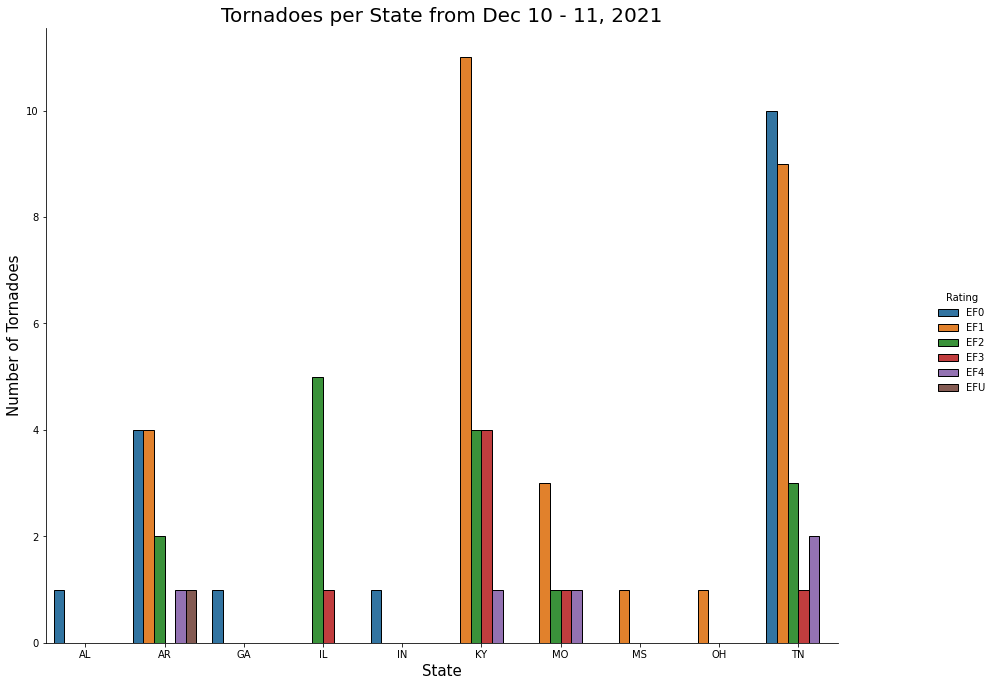

In [18]:
%matplotlib inline
graphable_storms = pd.melt(count_per_state, id_vars='State', var_name='Rating', value_name='Count')

# Plot the values
fig = plt.gcf()
storm_plot = sns.catplot(x='State', y='Count', hue='Rating', data=graphable_storms, kind='bar', edgecolor='black')
storm_plot.fig.set_figwidth(15)
storm_plot.fig.set_figheight(10)

plt.title('Tornadoes per State from Dec 10 - 11, 2021', size=20)
plt.ylabel('Number of Tornadoes', size=15)
plt.xlabel('State', size=15)

In [20]:
state_data

,Fujita_Rating,Location,County,Time_UTC,Summary,date_occured,Path_Length_mi,Path_Length_km,Width_yd,Width_m,State
0,EF0,SW of Emerald Mountain,Elmore,22:12,"A brief, weak tornado occurred just northeast ...",12-10-21,0.19,0.31,50,46,AL
68,EF4,"N of Bay, AR to Monette, AR to Braggadocio, MO...","Craighead (AR), Mississippi (AR), Dunklin (MO)...",01:07–02:36,7 deaths – See section on this tornado – At le...,12-10-21,81.20,130.70,1800,1600,AR
57,EF2,Northern Augusta to S of Tupelo,"Woodruff, Jackson",02:13–02:22,This tornado touched down in the northern part...,12-10-21,9.11,14.66,500,460,AR
47,EF2,Trumann,Poinsett,03:11–03:15,This strong tornado was spawned by an embedded...,12-10-21,3.60,5.80,250,230,AR
45,EF1,W of Jonesboro,Craighead,02:30–02:35,"A barn was damaged, and twelve utility poles w...",12-10-21,4.66,7.50,150,140,AR
...,...,...,...,...,...,...,...,...,...,...,...
5,EF0,Hermitage,Davidson,09:33–09:35,A tornado moved from near Interstate 40 at J. ...,12-11-21,1.38,2.22,50,46,TN
4,EF0,N of Gallatin to SW of Bethpage,Sumner,09:42–09:47,"An outbuilding was destroyed, a home sustained...",12-11-21,6.21,9.99,50,46,TN
3,EF0,N of Lebanon,"Wilson, Sumner",09:48–09:51,Several trees were downed along a path that cr...,12-11-21,3.07,4.94,50,46,TN
6,EF0,NE of Pegram to NNW of Downtown Nashville,Davidson,09:12–09:21,The tornado formed just east of where the King...,12-11-21,9.00,14.00,300,270,TN
